In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

df=pd.read_csv("diabetes_for_test.csv")
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


Outcome : y컬럼

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


<AxesSubplot:>

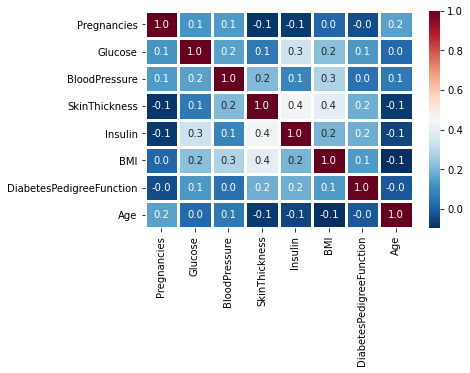

In [7]:
import seaborn as sns

df_cor=df.drop(columns=['Outcome']).corr(method='pearson')
sns.heatmap(df_cor, cmap='RdBu_r', annot=True, fmt='.1f', linewidth=3)

다중공선성은 없다고판단

- 이상치 식별

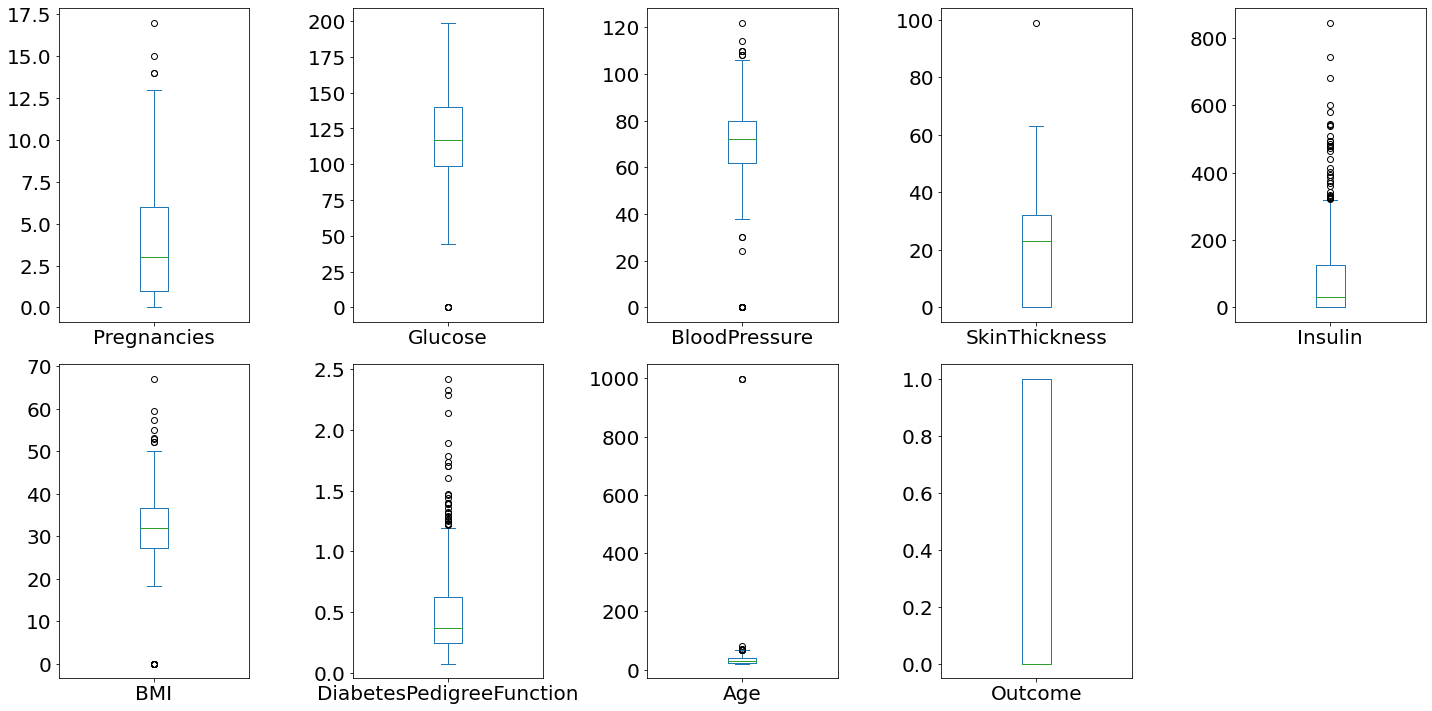

In [9]:
df.plot(kind='box', subplots=True, layout=(2,5), figsize=(20,10), fontsize=20)
plt.tight_layout()
plt.show()

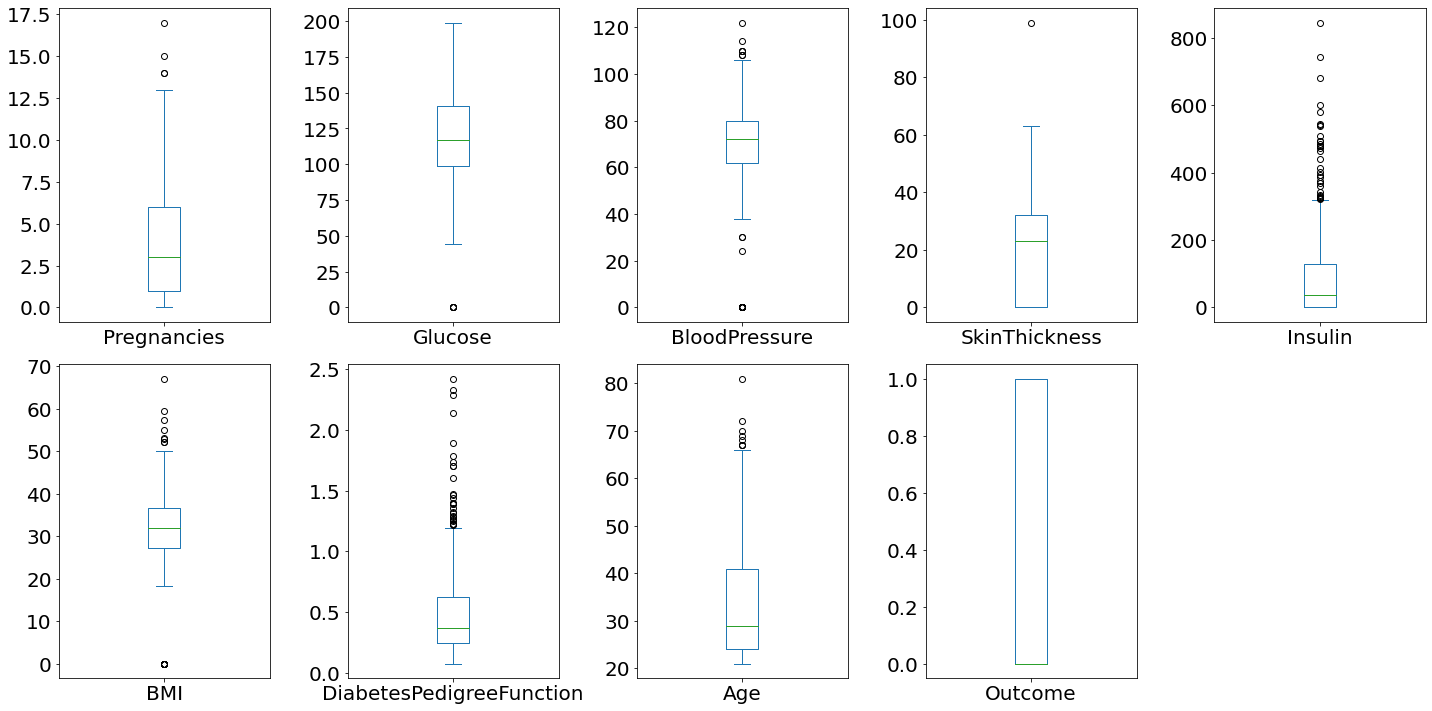

In [10]:
df=df[df['Age']<=200]
df.plot(kind='box', subplots=True, layout=(2,5), figsize=(20,10), fontsize=20)
plt.tight_layout()
plt.show()

In [13]:
index1=df[df['Glucose']==0].index
df.loc[index1, 'Glucose']=df['Glucose'].median()
index2=df[df['BloodPressure']==0].index
df.loc[index2, 'BloodPressure']=df['BloodPressure'].median()

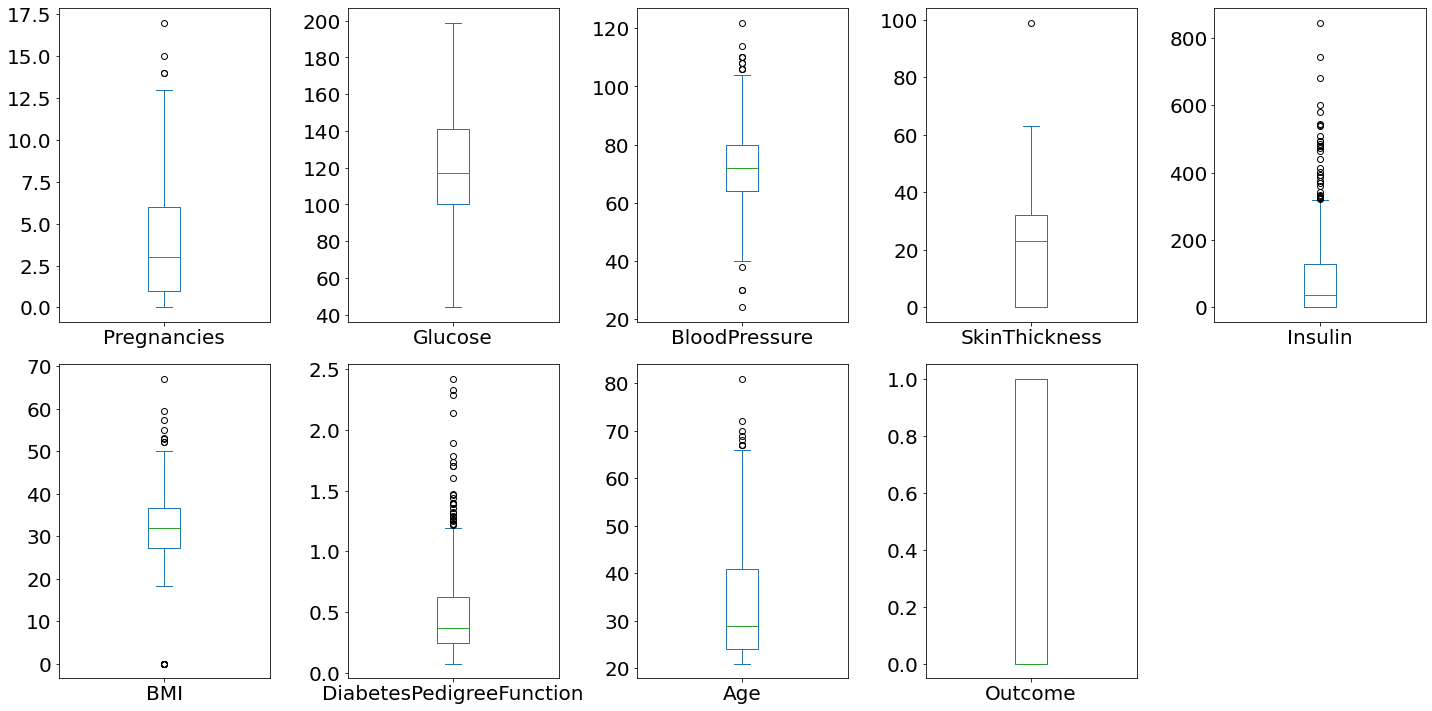

In [14]:
df.plot(kind='box', subplots=True, layout=(2,5), figsize=(20,10), fontsize=20)
plt.tight_layout()
plt.show()

In [16]:
df['Outcome'].value_counts()

0    497
1    268
Name: Outcome, dtype: int64

In [17]:
from imblearn.over_sampling import RandomOverSampler

X=df.drop(columns='Outcome')
y=df[['Outcome']]

In [18]:
ros=RandomOverSampler()
X_upsampling, y_upsampling=ros.fit_resample(X, y)

In [19]:
from imblearn.under_sampling import RandomUnderSampler
rus=RandomUnderSampler()
X_undersampling, y_undersampling=rus.fit_resample(X, y)

In [20]:
len(X_upsampling)

994

In [21]:
len(X)

765

In [22]:
len(X_undersampling)

536

- 모델링

In [23]:
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
import sklearn.svm as svm

log=LogisticRegression()
xgb=XGBClassifier(random_state=0)
svm_clf=svm.SVC(kernel='linear')

In [24]:
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
import time
from imblearn.over_sampling import SMOTE
smote=SMOTE(random_state=0)

In [26]:
kfold=KFold()
def model_result(model):
    pred_li=[]
    for train_index, test_index in kfold.split(X):
        X_train, X_test=X.iloc[train_index,:], X.iloc[test_index,:]
        y_train, y_test=y.iloc[train_index,:], y.iloc[test_index,:]
        X_train_resample, y_train_resample=smote.fit_resample(X_train, y_train)
        
        start=time.time()
        model.fit(X_train_resample, y_train_resample)
        end=time.time()
        
        pred=model.predict(X_test)
        pred_li.append(accuracy_score(pred, y_test['Outcome']))
        
    print(f'{end-start:.5f} sec')
    print(np.mean(pred_li))

In [27]:
model_result(log)

0.03990 sec
0.7254901960784313


In [28]:
model_result(xgb)

[16:31:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:31:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:31:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:31:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

In [29]:
model_result(svm_clf)

7.89171 sec
0.7542483660130719


Logistic이 가장 빠르고 svm이 성능이 가장 좋음

- 차원축소 후 분류

In [31]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

smote=SMOTE(random_state=0)
X_train, X_test, y_train, y_test=train_test_split(X, y, stratify=y, test_size=0.3, random_state=2022)

scaler=StandardScaler()
X_train_s=scaler.fit_transform(X_train)

X_train_s=scaler.fit_transform(X_train)
pca=PCA(n_components=8)
X_train_pca=pca.fit(X_train_s)

print(pca.explained_variance_ratio_)
print(pca.explained_variance_ratio_[:5].sum())

[0.26476468 0.22262299 0.11943967 0.10958623 0.10226337 0.08128701
 0.05075752 0.04927852]
0.8186769474239266


주성분 5개로 모델링 진행

In [33]:
def pca_model_result(model):
    pred_li=[]
    for train_index, test_index in kfold.split(X):
        X_train, X_test=X.iloc[train_index, :], X.iloc[test_index, :]
        y_train, y_test=y.iloc[train_index, :], y.iloc[test_index, :]
        
        X_train_resample, y_train_resample=smote.fit_resample(X_train, y_train)
        
        scaler=StandardScaler()
        X_train_res_s=scaler.fit_transform(X_train_resample)
        X_test_s=scaler.transform(X_test)
        
        pca=PCA(n_components=5)
        X_train_pca=pca.fit_transform(X_train_res_s)
        X_test_pca=pca.transform(X_test_s)
        
        start=time.time()
        model.fit(X_train_pca, y_train_resample)
        end=time.time()
        
        pred=model.predict(X_test_pca)
        pred_li.append(accuracy_score(pred, y_test['Outcome']))
        
    print(f"{end-start:.5f} sec")
    print(np.mean(pred_li))

In [34]:
pca_model_result(log)

0.00598 sec
0.7281045751633985


In [35]:
pca_model_result(xgb)

[16:44:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:44:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:44:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:44:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

In [36]:
pca_model_result(svm_clf)

0.07780 sec
0.7215686274509803
